Often in imaging it is common to reslice images in different resolutions. Especially in dMRI we usually want images with isotropic voxel size as they facilitate most tractography algorithms. In this example we show how you can reslice a dMRI dataset to have isotropic voxel size.

Let’s start by importing the necessary modules.

In [1]:
import nibabel as nib

from dipy.align.reslice import reslice
from dipy.data import get_fnames
from dipy.io.image import load_nifti, save_nifti

/home/jacob/comphy/Comphy/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We use here a very small dataset to show the basic principles but you can replace the following line with the path of your image.

In [2]:
fimg = get_fnames(name="aniso_vox")

We load the image, the affine of the image and the voxel size. The affine is the transformation matrix which maps image coordinates to world (mm) coordinates. Then, we print the shape of the volume

In [3]:
data, affine, voxel_size = load_nifti(fimg, return_voxsize=True)

print(f"Data size: {data.shape}")
print(f"Voxel size: {voxel_size}")

Data size: (58, 58, 24)
Voxel size: (np.float32(4.0), np.float32(4.0), np.float32(5.0))


Set the required new voxel size.

In [4]:
new_voxel_size = (3.0, 3.0, 3.0)
print(f"New Voxel size: {new_voxel_size}")

New Voxel size: (3.0, 3.0, 3.0)


Start resampling (reslicing). Trilinear interpolation is used by default.

In [5]:
data2, affine2 = reslice(data, affine, voxel_size, new_voxel_size)
print(f"New data size: {data2.shape}")

New data size: (77, 77, 40)


Save the result as a new Nifti file.

In [6]:
save_nifti("iso_vox.nii.gz", data2, affine2)

Or as analyze format or any other supported format.

In [7]:
img3 = nib.Spm2AnalyzeImage(data2, affine2)
nib.save(img3, "iso_vox.img")

In [9]:
import os
print(os.getcwd())  # Prints the directory where the file is saved


/home/jacob/DIPY


In [10]:
import nibabel as nib

# Load the Analyze image (.img/.hdr)
img = nib.load("iso_vox.img")

# Get image data as a NumPy array
data = img.get_fdata()

# Get the affine transformation matrix
affine = img.affine

# Print basic info
print("Data shape:", data.shape)
print("Affine matrix:\n", affine)


Data shape: (77, 77, 40)
Affine matrix:
 [[-2.99983996e+00 -4.36316532e-06 -3.09816353e-02  1.18763443e+02]
 [ 1.79954292e-02 -2.44229472e+00 -1.74208860e+00  1.32198181e+02]
 [-2.52195625e-02 -1.74218148e+00  2.44216461e+00  2.28195553e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


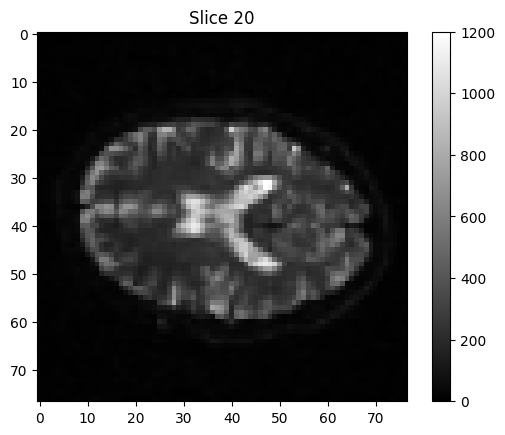

In [11]:
import matplotlib.pyplot as plt

# Select a middle slice along the Z-axis
slice_index = data.shape[2] // 2

# Plot the slice
plt.imshow(data[:, :, slice_index], cmap="gray")
plt.colorbar()
plt.title(f"Slice {slice_index}")
plt.show()


importing some essential functions ofr correwcting motion

In [12]:
from dipy.align import motion_correction
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, save_nifti

We choose one of the data from the datasets in dipy. However, you can replace the following line with the path of your image.

In [13]:
dwi_fname, dwi_bval_fname, dwi_bvec_fname = get_fnames(name="sherbrooke_3shell")

Lead image and affine of image.

In [14]:
data, affine = load_nifti(dwi_fname)
bvals, bvecs = read_bvals_bvecs(dwi_bval_fname, dwi_bvec_fname)

This data has 193 volumes. For this demo purpose, we decide to reduce the number of volumes to 3. However, we do not recommend to perform a motion correction with less than 10 volumes.

In [15]:
data_small = data[..., :3]
bvals_small = bvals[:3]
bvecs_small = bvecs[:3]
gtab = gradient_table(bvals_small, bvecs=bvecs_small)

Start motion correction of our reduced DWI dataset(between-volumes motion correction).

In [16]:
data_corrected, reg_affines = motion_correction(data_small, gtab, affine=affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


save to file

In [17]:
save_nifti(
    "motion_correction.nii.gz", data_corrected.get_fdata(), data_corrected.affine
)

NOISE ESTIMATION USING PIESNO

In this example, we will demonstrate the use of PIESNO with a 3-shell data-set.

We start by importing necessary modules and functions:


In [18]:
import matplotlib.pyplot as plt
import numpy as np

from dipy.data import get_fnames
from dipy.denoise.noise_estimate import piesno
from dipy.io.image import load_nifti, save_nifti

Then we load the data and the affine:

In [19]:
dwi_fname, dwi_bval_fname, dwi_bvec_fname = get_fnames(name="sherbrooke_3shell")
data, affine = load_nifti(dwi_fname)

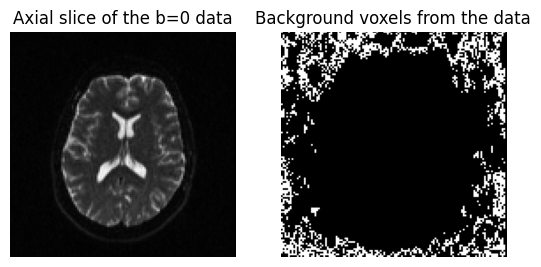

In [20]:
sigma, mask = piesno(data, N=4, return_mask=True)

axial = data[:, :, data.shape[2] // 2, 0].T
axial_piesno = mask[:, :, data.shape[2] // 2].T

fig, ax = plt.subplots(1, 2)
ax[0].imshow(axial, cmap="gray", origin="lower")
ax[0].set_title("Axial slice of the b=0 data")
ax[1].imshow(axial_piesno, cmap="gray", origin="lower")
ax[1].set_title("Background voxels from the data")
for a in ax:
    a.set_axis_off()

plt.savefig("piesno.png", bbox_inches="tight")

In [21]:
save_nifti("mask_piesno.nii.gz", mask.astype(np.uint8), affine)

print("The noise standard deviation is sigma = ", sigma)
print("The std of the background is =", np.std(data[mask[..., :].astype(bool)]))

The noise standard deviation is sigma =  [7.263329  7.263329  7.263329  6.933178  7.263329  6.933178  6.933178
 6.933178  6.933178  6.933178  6.933178  7.263329  7.263329  6.933178
 7.5934806 7.263329  7.5934806 7.263329  7.263329  7.263329  7.5934806
 7.263329  7.5934806 7.5934806 7.263329  7.263329  7.5934806 7.5934806
 7.263329  7.263329  7.263329  7.5934806 7.263329  7.263329  7.263329
 7.263329  7.263329  7.263329  7.263329  7.263329  7.263329  7.263329
 7.263329  6.933178  7.263329  6.933178  6.933178  6.933178  6.933178
 6.933178  7.263329  7.263329  7.263329  7.263329  7.263329  7.263329
 7.263329  7.263329  7.263329  7.263329 ]
The std of the background is = 9.708311737182022


Here, we obtained a noise standard deviation of 7.26. For comparison, a simple standard deviation of all voxels in the estimated mask (as done in the previous example SNR estimation for Diffusion-Weighted Images) gives a value of 6.1.

DENOISE IMAGES USING NON-LOCAL MEANS (NLMEANS)

Using the non-local means filter and and you can denoise 3D or 4D images and boost the SNR of your datasets. You can also decide between modeling the noise as Gaussian or Rician (default).

In [22]:
from time import time

import matplotlib.pyplot as plt
import numpy as np

from dipy.data import get_fnames
from dipy.denoise.nlmeans import nlmeans
from dipy.denoise.noise_estimate import estimate_sigma
from dipy.io.image import load_nifti, save_nifti

Then, let’s fetch and load a T1 data from Stanford University

In [23]:
t1_fname = get_fnames(name="stanford_t1")
data, affine = load_nifti(t1_fname)

mask = data > 1500

print("vol size", data.shape)

100%|██████████| 71/71 MB [00:06]

vol size (81, 106, 76)
